In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_pickle('/content/drive/MyDrive/choosen/train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/choosen/test.pkl')

In [ ]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTrainin = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(train_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTrainin.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTesting = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(test_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTesting.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

print("Image resizing completed.")

100%|██████████| 384/384 [06:15<00:00,  1.02it/s]

Image resizing completed.


In [ ]:
labels_one_hot = train_data.iloc[:, 1:].values
labelstrain = [list(row).index(1.0) for row in labels_one_hot]
labels_one_hot = test_data.iloc[:, 1:].values
labelstest = [list(row).index(1.0) for row in labels_one_hot]

stacked_array = np.stack(labelstrain)  # Shape: (num_samples, 3, 500, 500)
torch_labels_train = torch.from_numpy(stacked_array)

stacked_array = np.stack(labelstest)  # Shape: (num_samples, 3, 500, 500)
torch_labels_test = torch.from_numpy(stacked_array)

stacked_array = np.stack(imgsTrainin)  # Shape: (num_samples, 3, 500, 500)
torch_images_train = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

stacked_array = np.stack(imgsTesting)  # Shape: (num_samples, 3, 500, 500)
torch_images_test = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

In [ ]:
# Example data (replace with your actual tensors)
train_images = torch_images_train.permute(0, 3, 1, 2)
test_images = torch_images_test.permute(0, 3, 1, 2)
train_labels = torch_labels_train
test_labels = torch_labels_test

# Wrap into TensorDataset
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import vgg16
import torch.nn as nn
from torchvision.transforms import Normalize

# Normalize the dataset using ImageNet's mean and standard deviation
imagenet_normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_images = imagenet_normalize(train_images)
test_images = imagenet_normalize(test_images)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pretrained VGG-16 model
model = vgg16(pretrained=True)

# Modify the classifier to match your dataset's number of classes
num_classes = len(torch.unique(train_labels))  # Adjust based on your dataset
model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 171MB/s]


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
trainingHolder = []
testingHolder = []

epochs = 30  # Adjust the number of epochs as needed
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    # Evaluation loop
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  testingHolder.append(100 * correct / total)

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  trainingHolder.append(100 * correct / total)

  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/30, Loss: 3.7365
Epoch 2/30, Loss: 1.9642
Epoch 3/30, Loss: 1.8603
Epoch 4/30, Loss: 1.7123
Epoch 5/30, Loss: 1.5899
Epoch 6/30, Loss: 1.5104
Epoch 7/30, Loss: 1.4882
Epoch 8/30, Loss: 1.4744
Epoch 9/30, Loss: 1.3491
Epoch 10/30, Loss: 1.3533
Epoch 11/30, Loss: 1.1098
Epoch 12/30, Loss: 0.9237
Epoch 13/30, Loss: 0.8979
Epoch 14/30, Loss: 0.8211
Epoch 15/30, Loss: 0.9490
Epoch 16/30, Loss: 0.6224
Epoch 17/30, Loss: 0.4323
Epoch 18/30, Loss: 0.4605
Epoch 19/30, Loss: 0.5166
Epoch 20/30, Loss: 0.3609
Epoch 21/30, Loss: 0.3383
Epoch 22/30, Loss: 0.6218
Epoch 23/30, Loss: 0.3807
Epoch 24/30, Loss: 0.2079
Epoch 25/30, Loss: 0.0937
Epoch 26/30, Loss: 0.2247
Epoch 27/30, Loss: 0.3071
Epoch 28/30, Loss: 0.1998
Epoch 29/30, Loss: 0.1096
Epoch 30/30, Loss: 0.0746


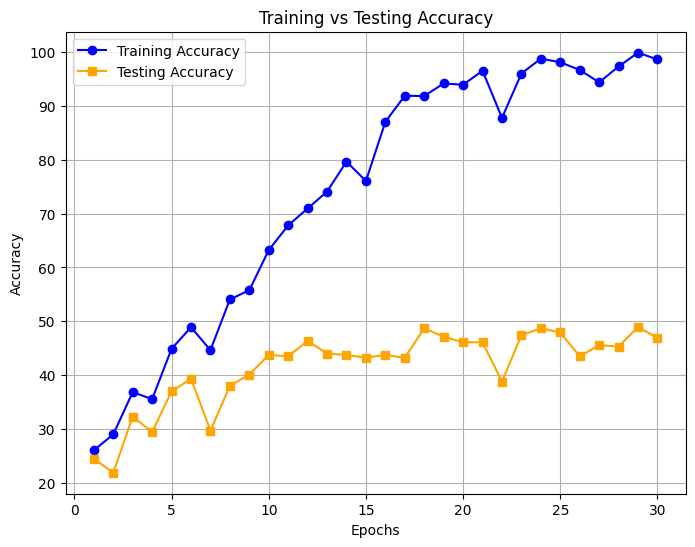

In [ ]:
epochs = range(1, len(trainingHolder) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, trainingHolder, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, testingHolder, label='Testing Accuracy', marker='s', color='orange')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
testingHolder

[24.479166666666668,
 21.875,
 32.291666666666664,
 29.427083333333332,
 36.979166666666664,
 39.322916666666664,
 29.6875,
 38.020833333333336,
 40.104166666666664,
 43.75,
 43.489583333333336,
 46.354166666666664,
 44.010416666666664,
 43.75,
 43.229166666666664,
 43.75,
 43.229166666666664,
 48.697916666666664,
 47.135416666666664,
 46.09375,
 46.09375,
 38.802083333333336,
 47.395833333333336,
 48.697916666666664,
 47.916666666666664,
 43.489583333333336,
 45.572916666666664,
 45.3125,
 48.958333333333336,
 46.875]

In [ ]:
max(testingHolder)